<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment1/workbook-task1.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: Modify this cell to add your group name, group number and your names and student IDs

Group: 42

Authors: Yaroslav Nazarov (1282875), Pol Timmer ()

In [107]:
import requests
import io
import pandas as pd
import xarray as xa
import torch
from torch import tensor

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load training/testing dataset

In [11]:
def load_dataset_from_url(url):
    """
    Loads a dataset from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    x: Input features in numpy array format
    y: Targets/labels in numpy array format
    """
    
    response = requests.get(url)
    response.raise_for_status()
    
    dataset = np.load(io.BytesIO(response.content)) 
    
    x, y = np.split(dataset, [9], axis=2)
    
    return x, y

def load_dataset_from_disk(path):
    """
    Loads a dataset from disk. 
    
    Input:
    path: path to the dataset.
    
    Outputs:
    x: Input features in numpy array format
    y: Targets/labels in numpy array format
    """
    
    
    dataset = np.load(path)
    
    x, y = np.split(dataset, [9], axis=2)
    
    return x, y
    
    
# Downloading may take a while..

train_x, train_y = load_dataset_from_disk("A1T2_train.npy")
test_x, test_y = load_dataset_from_disk("A1T2_test.npy")


print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}\n")

print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")

train_x shape: (10000, 1000, 9)
train_y shape: (10000, 1000, 1)

test_x shape: (2000, 1000, 9)
test_y shape: (2000, 1000, 1)


### Visualize some of the training samples

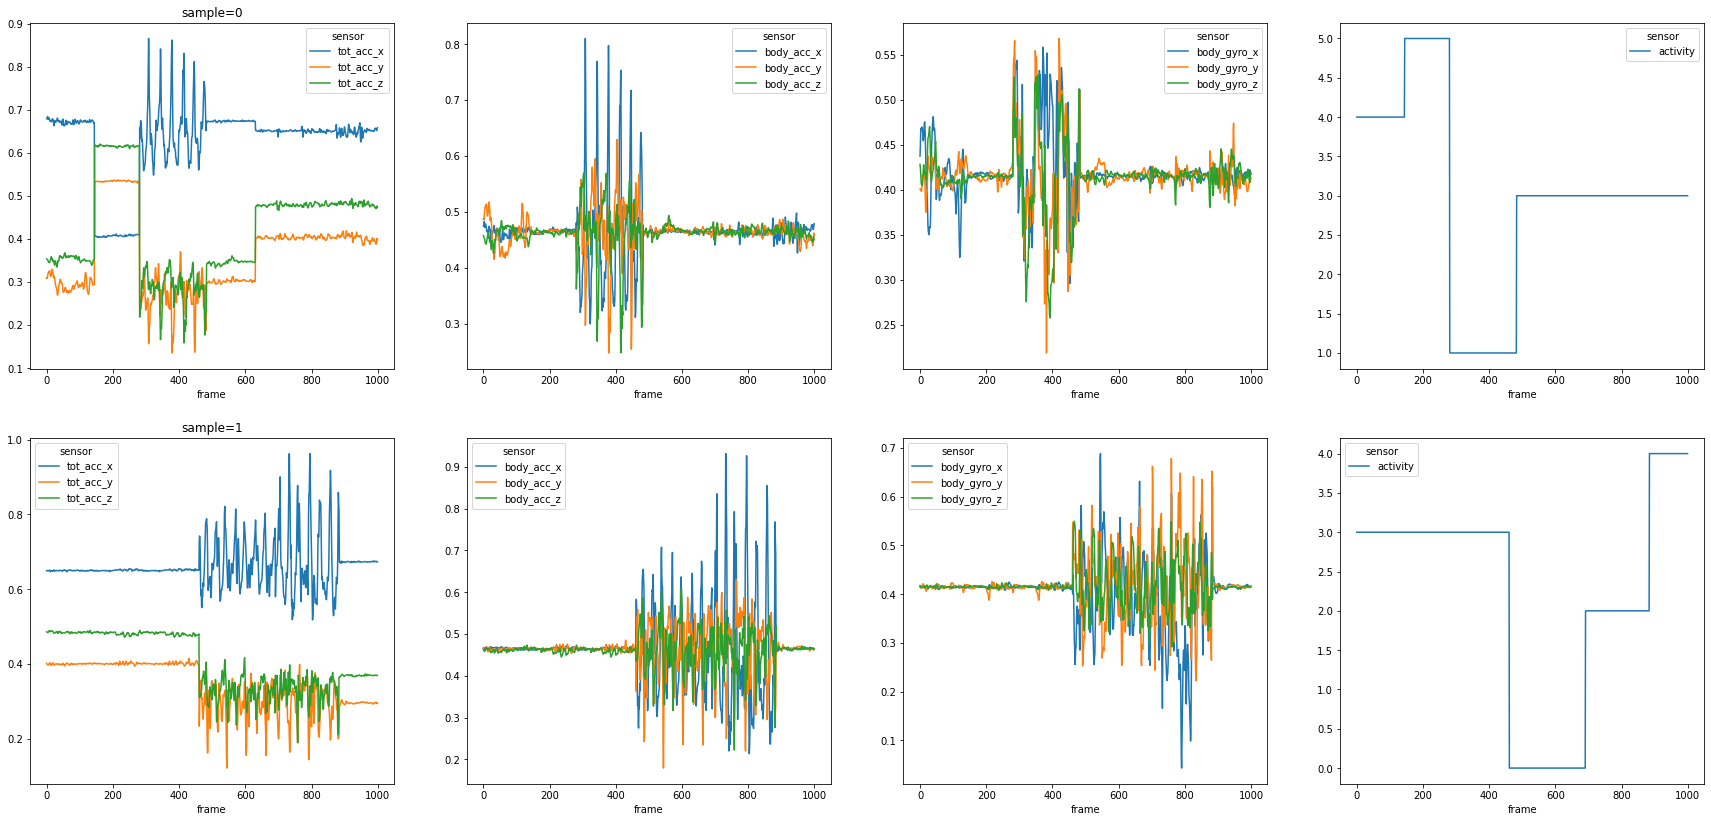

In [12]:
def to_df(x, y):
    """
    Converts training/testing input features and corresponding labels into
    a Pandas Dataframe format
    
    Inputs:
    x: Input features (train or test) in numpy array format
    y: Targets/labels (train or test) in numpy array format
    
    Output:
    dataset_df: Train or test data, structered as a table with column names
    """
    
    numpy_data = np.concatenate([x,y], axis=2)
    
    dataset_df = xa.DataArray(numpy_data, 
                                     dims = ['N', 'frame', 'sensor'],
                                     name='training_data')\
                                        .to_dataframe()\
                                        .unstack('sensor')['training_data']\
                                        .reset_index()

    column_names = ['tot_acc_x', 'tot_acc_y', 'tot_acc_z', 'body_acc_x', 'body_acc_y',
       'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'activity']
    
    dataset_df = dataset_df.rename(columns = dict(zip(list(dataset_df.columns[2:]), 
                                                      column_names)))\
                                         .astype({'activity':int})

    return dataset_df



def plot_training_samples(N, dataset_df):
    """
    Plots samples in test/train dataset
    
    Inputs 
    N: Number of samples that will be visualised. 
    dataset_df: Train or test data, structered as a table with column names. 
                This tabular structured data can be obtained with `to_df` function.
    """
    
    f, axes = plt.subplots(N, 4, figsize=(30, N*7))
    axes = iter(axes)

    for pid, df_pid in list(dataset_df.groupby('N'))[:N]:

        ax_tot_acc, ax_body_acc, ax_body_gyro, ax_activity = tuple(next(axes))

        df_pid.plot(x = 'frame', y=['tot_acc_x','tot_acc_y', 'tot_acc_z'], title=f'sample={pid}', ax=ax_tot_acc)
        df_pid.plot(x = 'frame', y=['body_acc_x','body_acc_y', 'body_acc_z'], ax=ax_body_acc)
        df_pid.plot(x = 'frame', y=['body_gyro_x','body_gyro_y', 'body_gyro_z'], ax=ax_body_gyro)
        df_pid.plot(x = 'frame', y=['activity'], ax=ax_activity) 
        
    
    

training_data_df = to_df(train_x, train_y)

plot_training_samples(2, training_data_df);

In [110]:
from scipy.stats import mode

train_x_split = np.moveaxis(np.array(np.split(train_x, 20, axis=1)), [0,1,2,3], [1, 0, 3, 2])
train_y_split = mode(np.moveaxis(np.array(np.split(train_y, 20, axis=1)), [0,1,2,3], [1, 0, 3, 2]), axis=3).mode

test_x_split = np.moveaxis(np.array(np.split(test_x, 20, axis=1)), [0,1,2,3], [1, 0, 3, 2])
test_y_split = mode(np.moveaxis(np.array(np.split(test_y, 20, axis=1)), [0,1,2,3], [1, 0, 3, 2]), axis=3).mode

In [111]:
train_x_split = tensor(train_x_split, dtype=torch.float).to(device)
train_y_split = tensor(train_y_split, dtype=torch.float).to(device)
test_x_split = tensor(test_x_split, dtype=torch.float).to(device)
test_y_split = tensor(test_y_split, dtype=torch.float).to(device)

In [112]:
print(train_x_split.shape)
print(train_y_split.shape)
print(test_x_split.shape)
print(test_y_split.shape)

torch.Size([10000, 20, 9, 50])
torch.Size([10000, 20, 1, 1])
torch.Size([2000, 20, 9, 50])
torch.Size([2000, 20, 1, 1])


In [95]:
print(np.unique(test_y_split))

[0. 1. 2. 3. 4. 5.]


In [108]:
from torch.utils.data import TensorDataset, DataLoader


train_dataset = TensorDataset(train_x_split, train_y_split)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = TensorDataset(test_x_split, test_y_split)

test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [90]:
#TODO Implement the solution to task 2 of assignment 1
from torch import nn

In [52]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class CNNEmbedding(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        # input size (9, 50)
        kernel_size = 5
        padding = int((kernel_size-1)/2)
        self.layer1 = nn.Sequential(
            nn.Conv1d(9, 32, kernel_size=kernel_size, padding = padding), 
            nn.ReLU(), #50
            # nn.Dropout2d(0.05),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2),
            #25
            nn.Conv1d(32, 64, kernel_size=kernel_size, stride=2, padding = padding),
            nn.ReLU(),
            # nn.Dropout2d(0.05),
            nn.BatchNorm1d(64), #13
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=kernel_size, stride=2, padding = padding),
            nn.ReLU(),
            # nn.Dropout2d(0.05),
            nn.BatchNorm1d(128), #7
            nn.MaxPool1d(2),

            # nn.Conv1d(32, 64, kernel_size=kernel_size, stride=2, padding = padding),
            # nn.ReLU(),
            # # nn.Dropout2d(0.05),
            # nn.BatchNorm1d(16), #4
            # # nn.MaxPool1d(2),

            Lambda(lambda x: x.reshape(x.size(0), -1)),
            
        )

        self.layer2 = nn.Linear(self.get_out_size(self.layer1, (1, 9, 50)), embed_dim)
    def forward(self, frame):
        out = self.layer1(frame)
        return self.layer2(out)

    def get_out_size(self, module, input_dims):
        fake_input = torch.rand(*input_dims, dtype=torch.float)
        output = module(fake_input)
        return output.view(1, -1).size()[1]


In [54]:
model = CNNEmbedding(8)
print(model(torch.Tensor(train_x_split[0])).shape)

torch.Size([20, 8])


In [66]:
class RNNClassificationModel(nn.Module):

    def __init__(self, embed_dim, n_layers, hidden_dim, num_class):
        super(RNNClassificationModel, self).__init__()
        
        # save some parameters
        self.n_layers = n_layers
        self.embed_dim = embed_dim
        
        self.window_embeddings = CNNEmbedding(embed_dim)
        
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True)

        self.back_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_class),
        )
        
        # self.drop = nn.Dropout(p=0.5)
        
        self.criterion = nn.CrossEntropyLoss()
        
        self.optimizer = torch.optim.Adam(self.parameters())
        

    def forward(self, frame):
        
        # input shapes:
        # text: [batch_size, max. sequence length in batch]
        
        
        # embed sequences with word embedding
        # shape [batch_size, max. sequence length in batch, embed_dim]
        flat = frame.view(-1, 9, 50)

        h = self.window_embeddings(flat).view(-1, 20, self.embed_dim)    
    
        # Feed packed input sequence to lstm 
        out, (hidden, _) = self.rnn(h)
    
        return self.back_layer(out)

In [69]:
model2 = RNNClassificationModel(8, 2, 10, 4)
print(model2(torch.Tensor(train_x_split[0:4])).shape)

torch.Size([4, 20, 4])


In [128]:
import time
from torch.nn.functional import softmax

def train(dataloader):
    
    model.train()
    
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (frames, labels) in enumerate(dataloader):
        
        model.optimizer.zero_grad()
        
        y_pred = model(frames) #shape (batch_size, num_classes) 
        

        y_class = y_pred.argmax(dim=-1, keepdims=True) 

        
#         y_prob = softmax(y_pred, dim=-1)  #alternatively, one can assign probabilities to each class with softmax activation
        
        loss = model.criterion(y_class, labels.view(4,20))

        print(loss)

        break
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        model.optimizer.step()
        
        
        
        total_acc += (y_class == labels).sum().item()
        total_count += y_true.size(0)
        
        
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()
            
    return total_acc/total_count

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (y_true, text_batch) in enumerate(dataloader):
            
            y_pred = model(text_batch) #shape (batch_size, num_classes) 
            
            y_class = y_pred.argmax(dim=-1) 
            
#             y_prob = softmax(y_pred, dim=-1)  #alternatively, one can assign probabilities to each class with softmax activation
            
            loss = model.criterion(y_pred, y_true)
            
            total_acc += (y_class == y_true).sum().item()
            total_count += y_true.size(0)

    return total_acc/total_count

In [129]:
# hyperparameters
EPOCHS = 10 # epoch
BATCH_SIZE = 4 # batch size for training/validation


# initiate recurrent classification model
model = RNNClassificationModel(embed_dim=500, 
                               n_layers = 2, 
                               hidden_dim=8, 
                               num_class=6).to(device)



# training loop
train_loss, val_loss = [], []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    
    train_dataloader = DataLoader(TensorDataset(tensor(train_x_split), tensor(train_y_split)), batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(TensorDataset(tensor(test_x_split), tensor(test_y_split)), batch_size=BATCH_SIZE, shuffle=True)
    
    train_loss.append(train(train_dataloader))
    val_loss.append(evaluate(test_dataloader))
    
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           val_loss[-1]))
    print('-' * 59)


<ipython-input-129-8cd32e70063a>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataloader = DataLoader(TensorDataset(tensor(train_x_split), tensor(train_y_split)), batch_size=BATCH_SIZE, shuffle=True)
<ipython-input-129-8cd32e70063a>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataloader = DataLoader(TensorDataset(tensor(test_x_split), tensor(test_y_split)), batch_size=BATCH_SIZE, shuffle=True)


RuntimeError: "host_softmax" not implemented for 'Long'